In [1]:
import torch
import pandas as pd
import numpy as np
import importlib
import ModelRunner as MR
import MakeDataset as MD

In [2]:
# Load the dataset. 
# molecule_features: First col is a string containing name of molecule. Rest are floats containing its features
# eutectic_compilation: First 2 cols are strings containing molecule names, third col is eutectic proportion, fourth is eutectic temperature

molecule_features = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\single_components.csv").drop(["xlogp"], axis=1)
eutectic_compilation = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\eutectic_compilation.csv")

molecule_features[molecule_features.columns[1:]] = molecule_features[molecule_features.columns[1:]].astype(float)
eutectic_compilation[eutectic_compilation.columns[3]] = eutectic_compilation[eutectic_compilation.columns[3]].astype(float)

In [3]:
# Some indices in eutectic_compilation do not exist in single_components. They will need to be removed.
# Some of the eutectic proportions are inconvertible to floats from strings. They will also need to be removed.
# missing_molecules will store all molecules that are missing features from eutectic_compilation
drops = np.array([]).astype(int)
missing_molecules = np.array([]).astype(str)
for i in range(len(eutectic_compilation)):
    ec = eutectic_compilation.iloc[i]
    m1 = ec[0]
    m2 = ec[1]
    xe = ec[2]
    
    m1f = molecule_features.loc[molecule_features.mol == ec[0]]
    m2f = molecule_features.loc[molecule_features.mol == ec[1]]
    
    try:
        xe = float(xe)
    except ValueError:
        drops = np.append(drops, i)
    
    if(len(m1f) == 0 or len(m2f) == 0):
        drops = np.append(drops, i)
        
        if(len(m1f) == 0):
            missing_molecules = np.append(missing_molecules, m1)
        elif(len(m2f) == 0):
            missing_molecules = np.append(missing_molecules, m2)

eutectic_compilation = eutectic_compilation.drop(eutectic_compilation.index[drops])
# np.savetxt("missing_molecules.csv", missing_molecules, delimiter=",", fmt="%s")

In [4]:
# Split the eutectic compilation dataframe by a ratio into training and testing sets
split = 0.95
train_ec = eutectic_compilation.sample(frac=split)
test_ec = eutectic_compilation.drop(train_ec.index)

split = 0.10
val_ec = train_ec.sample(frac=split)
train_ec = train_ec.drop(val_ec.index)

In [5]:
molecule_features

,mol,molecular_weight,complexity,rotatable_bond_count,heavy_atom_count,topological_area
0,BaO,153.3300,2.0,0.0,2.0,17.1
1,CrCl3,158.3500,0.0,0.0,4.0,0.0
2,PBr5,430.4900,37.1,0.0,6.0,0.0
3,WCl5,361.1000,37.1,0.0,6.0,0.0
4,HgI2,454.4000,2.8,0.0,3.0,0.0
...,...,...,...,...,...,...
672,PBr3,270.6900,8.0,0.0,4.0,0.0
673,PbSiO3,283.0000,18.8,0.0,5.0,63.2
674,LiI,133.9000,2.0,0.0,2.0,0.0
675,EuF3,208.9590,8.0,0.0,4.0,0.0


In [6]:
train_ec

,molA,molB,xe,Te
3633,PbCrO4,PbO,47,820.0
294,AgNO3,KNO3,62,131.9
1337,KCl,K2Cr2O7,27.5,366.0
1801,K2SO4,ZnSO4,23,475.0
724,LiC2H3O2,NaNO3,80,27.0
...,...,...,...,...
2958,KCl,TiCl3,85.2,676.0
2876,RbCl,TiCl3,90,662.0
1315,MgCl2,TlCl,27.5,360.0
2315,LiBO2,LiCl,19,572.0


In [7]:
val_ec

,molA,molB,xe,Te
3158,GaAs,GaSb,3,708.0
1840,K2MoO4,MoO3,47.6,484.0
2602,FeCl2,LaCl3,72.3,620.0
3996,SrI2,Sr3N2,30,1050.0
1439,LiCl,TlBr,23,392.0
...,...,...,...,...
3937,DyF3,NaF,70,982.0
1142,CsCl,LiCl,42.5,314.0
1423,CsCl,PbI2,77.7,386.0
2259,RbCl,RbI,4.5,560.0


In [8]:
test_ec

,molA,molB,xe,Te
14,BBr3,SiCl4,26.4,-80.0
17,KNH2,NH3,99,-78.8
18,BBr3,GeCl4,40,-74.0
20,SiCl4,WCl6,100,-70.0
42,GaCl3,TiCl4,10,-25.0
...,...,...,...,...
4354,Er2O3,GeO2,65,1900.0
4412,Cr2O3,ZrO2,61,2087.0
4441,SiO2,ZrO2,42,2220.0
4447,Dy2O3,SrO,70,2250.0


In [9]:
print(molecule_features.columns)
print(eutectic_compilation.columns)

Index(['mol', 'molecular_weight', 'complexity', 'rotatable_bond_count',
       'heavy_atom_count', 'topological_area'],
      dtype='object')
Index(['molA', 'molB', 'xe', 'Te'], dtype='object')


In [10]:
print(molecule_features.dtypes)
print(eutectic_compilation.dtypes)

mol                      object
molecular_weight        float64
complexity              float64
rotatable_bond_count    float64
heavy_atom_count        float64
topological_area        float64
dtype: object
molA     object
molB     object
xe       object
Te      float64
dtype: object


In [11]:
molecule_features.iloc[0]

mol                        BaO
molecular_weight        153.33
complexity                 2.0
rotatable_bond_count       0.0
heavy_atom_count           2.0
topological_area          17.1
Name: 0, dtype: object

In [12]:
print("Train Size: ", len(train_ec))
print("Validation Size: ", len(val_ec))
print("Test Size: ", len(test_ec))

Train Size:  3403
Validation Size:  378
Test Size:  199


In [13]:
importlib.reload(MD)

<module 'MakeDataset' from 'D:\\Research\\UConn_ML\\Code\\MakeDataset.py'>

In [14]:
# Define parameters and datasets to pass into trainer. Pass in order of definition
starting_features = 5
batchsize = 25
num_epochs = 20
lrmin = 1e-6
lrmax = 1e-5
train_dset = MD.MD(train_ec, molecule_features, starting_features)
val_dset = MD.MD(val_ec, molecule_features, starting_features)
test_dset = MD.MD(test_ec, molecule_features, starting_features)

# Set the baselines for training, validation, and testing
# MSE is basically variance, so the baseline is the variance of the dataset
train_base = torch.std(torch.tensor(np.array(train_ec["xe"]).astype(float) / 100.0))**2
val_base = torch.std(torch.tensor(np.array(val_ec["xe"]).astype(float) / 100.0))**2
test_base = torch.std(torch.tensor(np.array(test_ec["xe"]).astype(float) / 100.0))**2

# train_base = torch.std(torch.tensor(np.array(train_ec["Te"])))**2
# val_base = torch.std(torch.tensor(np.array(val_ec["Te"])))**2
# test_base = torch.std(torch.tensor(np.array(test_ec["Te"])))**2

train_param = "xe"

Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0045e-06.
Epoch 1 | Train Loss: 20.103 | Train Baseline: 35.292 | Val Loss: 2.575 | Val Baseline: 3.904
Adjusting learning rate of group 0 to 1.0090e-06.
Epoch 2 | Train Loss: 20.075 | Train Baseline: 35.473 | Val Loss: 2.33 | Val Baseline: 4.09
Adjusting learning rate of group 0 to 1.0135e-06.
Early Stopping. Resetting Weights.
Epoch 3 | Train Loss: 20.114 | Train Baseline: 35.237 | Val Loss: 2.441 | Val Baseline: 3.847
Adjusting learning rate of group 0 to 1.0180e-06.
Early Stopping. Resetting Weights.
Epoch 4 | Train Loss: 19.832 | Train Baseline: 35.292 | Val Loss: 2.643 | Val Baseline: 3.699
Adjusting learning rate of group 0 to 1.0225e-06.
Early Stopping. Resetting Weights.
Epoch 5 | Train Loss: 19.812 | Train Baseline: 35.394 | Val Loss: 2.567 | Val Baseline: 3.918
Adjusting learning rate of group 0 to 1.0270e-06.
Early Stopping. Resetting Weights.
Epoch 6 | Train Loss: 19.843 | Train Basel

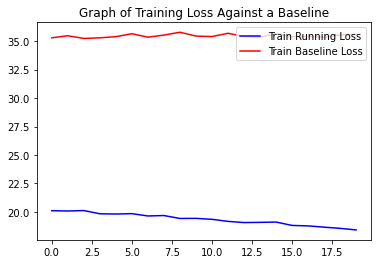

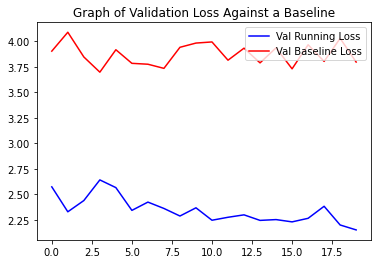

Test Loss: 1.064 | Test Baseline: 2.261



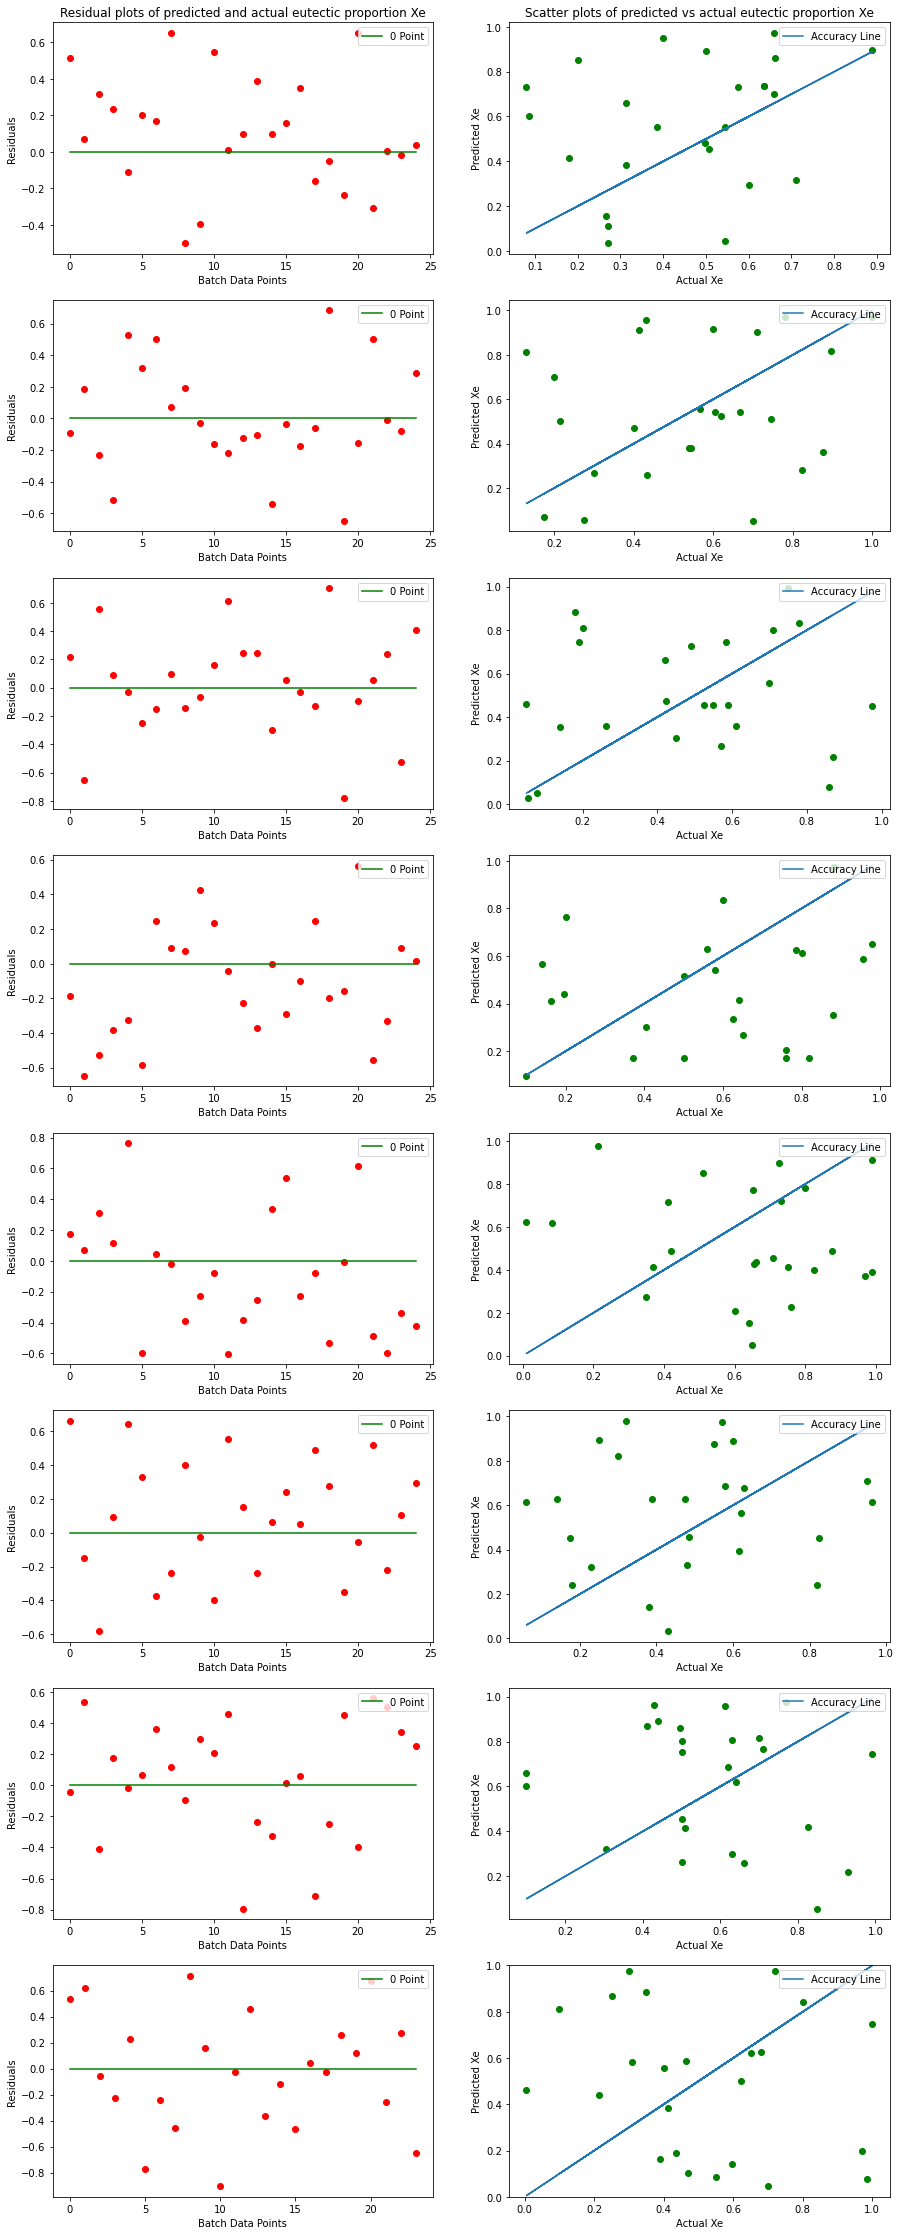

f(A,B): 
 tensor([0.8854, 0.8683, 0.6259, 0.1654, 0.4405, 0.1977, 0.1906, 0.1398, 0.8131,
        0.5559, 0.0781, 0.3850, 0.4636, 0.1039, 0.4998, 0.0836, 0.8432, 0.6206,
        0.9780, 0.5851, 0.9767, 0.7451, 0.5835, 0.0470])


f(B,A): 
 tensor([0.1146, 0.1317, 0.3741, 0.8346, 0.5595, 0.8023, 0.8094, 0.8602, 0.1869,
        0.4441, 0.9219, 0.6150, 0.5364, 0.8961, 0.5002, 0.9164, 0.1568, 0.3794,
        0.0220, 0.4149, 0.0233, 0.2549, 0.4165, 0.9530])


f(A,B) + f(B,A): 
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


Original Values: 
 tensor([0.3490, 0.2500, 0.6790, 0.3900, 0.2130, 0.9700, 0.4340, 0.5970, 0.1000,
        0.4000, 0.9840, 0.4130, 0.0050, 0.4700, 0.6210, 0.5500, 0.8000, 0.6500,
        0.7200, 0.4650, 0.3000, 1.0000, 0.3080, 0.7000])


Predicted Values: 
 tensor([0.8854, 0.8683, 0.6259, 0.1654, 0.4405

In [16]:
# Call training and testing class and send all required parameters 
importlib.reload(MR)
modelrunner = MR.MR(starting_features, batchsize, num_epochs, lrmin, lrmax, 
                    train_dset, val_dset, test_dset, 
                    train_base, val_base, test_base, 
                    train_param)

modelrunner.train_and_validate()
modelrunner.test_plot_stats()